# Infer ***cytoplasm*** -  3️⃣

--------------

## OVERVIEW
We will start by segmenting the different cell regions - the nucleus, cell, and cytoplasm - since they will be necessary for determining which organelle are in which cell. This is integral to our single cell analysis approach.

This notebook goes through the workflow steps to segment the ***cytoplasm*** -- the cellmask minus the nucleus area.

## OBJECTIVE:  
### ✅ Infer sub-cellular component #3: ***cytoplasm***
Segment the ***cytoplasm*** from the cellmask and nuclei outputs. We will first select the single nucleus that is within our cellmask. Then, a logical and will be applied to produce the cytoplasmic area.


## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys

import numpy as np

from skimage.morphology import binary_erosion

import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc.core.file_io import (read_czi_image,
                                     read_ome_image,
                                     export_inferred_organelle,
                                     import_inferred_organelle,
                                     list_image_files)
from infer_subc.core.img import *
from infer_subc.organelles import infer_cellmask_fromcomposite, fixed_infer_cellmask_fromcomposite, infer_nuclei_fromlabel, get_cellmask, get_nuclei
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc.constants import (TEST_IMG_N,
                                  NUC_CH ,
                                  LYSO_CH ,
                                  MITO_CH ,
                                  GOLGI_CH ,
                                  PEROX_CH ,
                                  ER_CH ,
                                  LD_CH ,
                                  RESIDUAL_CH)


%load_ext autoreload
%autoreload 2


## Get and load Image for processing

In [2]:
test_img_n = TEST_IMG_N

data_root_path = Path(os.path.expanduser("~")) / "Documents/Python Scripts/Infer-subc-2D"

in_data_path = data_root_path / "raw"
im_type = ".czi"

img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

out_data_path = data_root_path / "out"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [3]:
img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\ome_types\_convenience.py:112: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


----------
##  infer ***cytoplasm***

### summary of steps

➡️ INPUT (extract)
- segmented ***nuclei*** objects (from [01_infer_nuclei](./02_infer_cellmask_from-composite.ipynb))
- segmented ***cellmask*** object (from [02_infer_cellmask_from-composite](./02_infer_cellmask_from-composite.ipynb))

PRE-PROCESSING
  - N/A

CORE PROCESSING
  - mask nuclei with ***cellmask*** to select single ***nucleus***
  - erode ***nucleus*** (shrink; *optional*)
  - XOR(***nucleus***, ***cellmask***)

POST-PROCESSING
  - N/A

OUTPUT ➡️ 
  - save single ***nucleus*** (nuc, N1) at unsigned integer 8-bit tif files
  - save ***cytoplasm*** (cyto, CY) at unsigned integer 8-bit tif files

## GET nuclei segmentation output

In [4]:
nuclei =  get_nuclei(img_data,meta_dict, out_data_path)

loaded  inferred 3D `nuclei`  from C:\Users\Shannon\Documents\Python Scripts\Infer-subc-2D\out 


## GET cellmask segmentation output

In [5]:
cellmask = get_cellmask(img_data, nuclei, meta_dict, out_data_path)

loaded  inferred 3D `cell`  from C:\Users\Shannon\Documents\Python Scripts\Infer-subc-2D\out 


In [6]:
cellmask.dtype

dtype('uint16')

## EXTRACTION prototype

No extraction steps needed for this workflow.

## PRE-PROCESSING prototype

No pre-processing steps needed for this workflow.

## CORE PROCESSING prototype

In [7]:
###################
# CORE_PROCESSING
###################
# mask the nuclei segmentation with the cellmask to select the single nucleus
nucleus_obj =  apply_mask(nuclei, cellmask) 

# erode nucleus if desired (this likely depends on the type of label used)
nucleus_eroded = binary_erosion(nucleus_obj)

# select the cytoplasmic area (two ways shown here)
cyto_object = np.logical_and(cellmask,~nucleus_eroded)
cyto_object_xor = np.logical_xor(cellmask,nucleus_eroded)

nucleus_out = nucleus_obj.astype(np.uint8)
cytoplasm_out = cyto_object_xor.astype(np.uint8)

In [8]:
nucleus_out.dtype, cytoplasm_out.dtype

(dtype('uint8'), dtype('uint8'))

## POST-PROCESSING prototype

No post-processing steps needed for this workflow.

## LABELING prototype

No labeling steps needed for this workflow.

## Visualize with `napari` 

In [9]:
viewer = napari.view_image(cellmask, opacity=0.3)

In [10]:
viewer.add_image(
    nucleus_eroded,
    opacity=0.3)    

viewer.add_image(
    nucleus_obj,
    opacity=0.3) 

viewer.add_image(
    cyto_object_xor,
    opacity=0.3) 

<Image layer 'cyto_object_xor' at 0x26e553a8d30>

## SAVE inferred nucleus and cytoplasm to .tif file

In [11]:
out_file_n = export_inferred_organelle(nucleus_out, "nuc", meta_dict, out_data_path)
out_file_c = export_inferred_organelle(cytoplasm_out, "cyto", meta_dict, out_data_path)

saved file: a24hrs-Ctrl_14_Unmixing-nuc
saved file: a24hrs-Ctrl_14_Unmixing-cyto


----------
## DEFINE `_infer_cytoplasm` function

Based on the _prototyping_ above define the function to infer cytoplasm.  

> NOTE: these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use.

In [12]:
def _infer_cytoplasm(nuclei_object, cellmask,  erode_nuclei = True):
    """
    Procedure to infer cytoplasm from linearly unmixed input.

    Parameters
    ------------
    nuclei_object: 
        a 3d image containing the nuclei signal
    cellmask: 
        a 3d image containing the cellmask signal
    erode_nuclei: 
        should we erode? Default False

    Returns
    -------------
    cytoplasm_mask 
        boolean np.ndarray
      
    """
    nucleus_obj =  apply_mask(nuclei_object, cellmask) 

    if erode_nuclei:
        # cytoplasm_mask = np.logical_and(cellmask, ~binary_erosion(nuclei_object))
        cytoplasm_mask = np.logical_xor(cellmask, binary_erosion(nucleus_obj))
    else:
        # cytoplasm_mask = np.logical_and(cellmask, ~nuclei_object)
        cytoplasm_mask = np.logical_xor(cellmask, nucleus_obj)

    return cytoplasm_mask.astype(np.uint8)

## TEST `_infer_cytoplasm` function defined above

In [13]:
_CY_object = _infer_cytoplasm(nuclei, cellmask, erode_nuclei=True)

_CY_object.dtype

dtype('uint8')

In [14]:
np.all(cytoplasm_out == _CY_object)

True

--------------------------

## TEST `infer_cytoplasm` exported functions


The prototype `_infer_cytoplasm` was copied to the [`.organelles.cytoplasm`](../infer_subc/organelles/cytoplasm.py) sub-module.

In [15]:
from infer_subc.organelles.cytoplasm import infer_cytoplasm
cytoplasm_mask =  infer_cytoplasm(nuclei, cellmask, erode_nuclei=True) 

cytoplasm_mask.dtype

dtype('uint8')

In [16]:
np.all(_CY_object == cytoplasm_mask)

True

## Visualize  2


In [17]:
viewer.add_image(
    cytoplasm_mask)

viewer.add_labels(
    cytoplasm_mask)

<Labels layer 'cytoplasm_mask [1]' at 0x26e495e70a0>

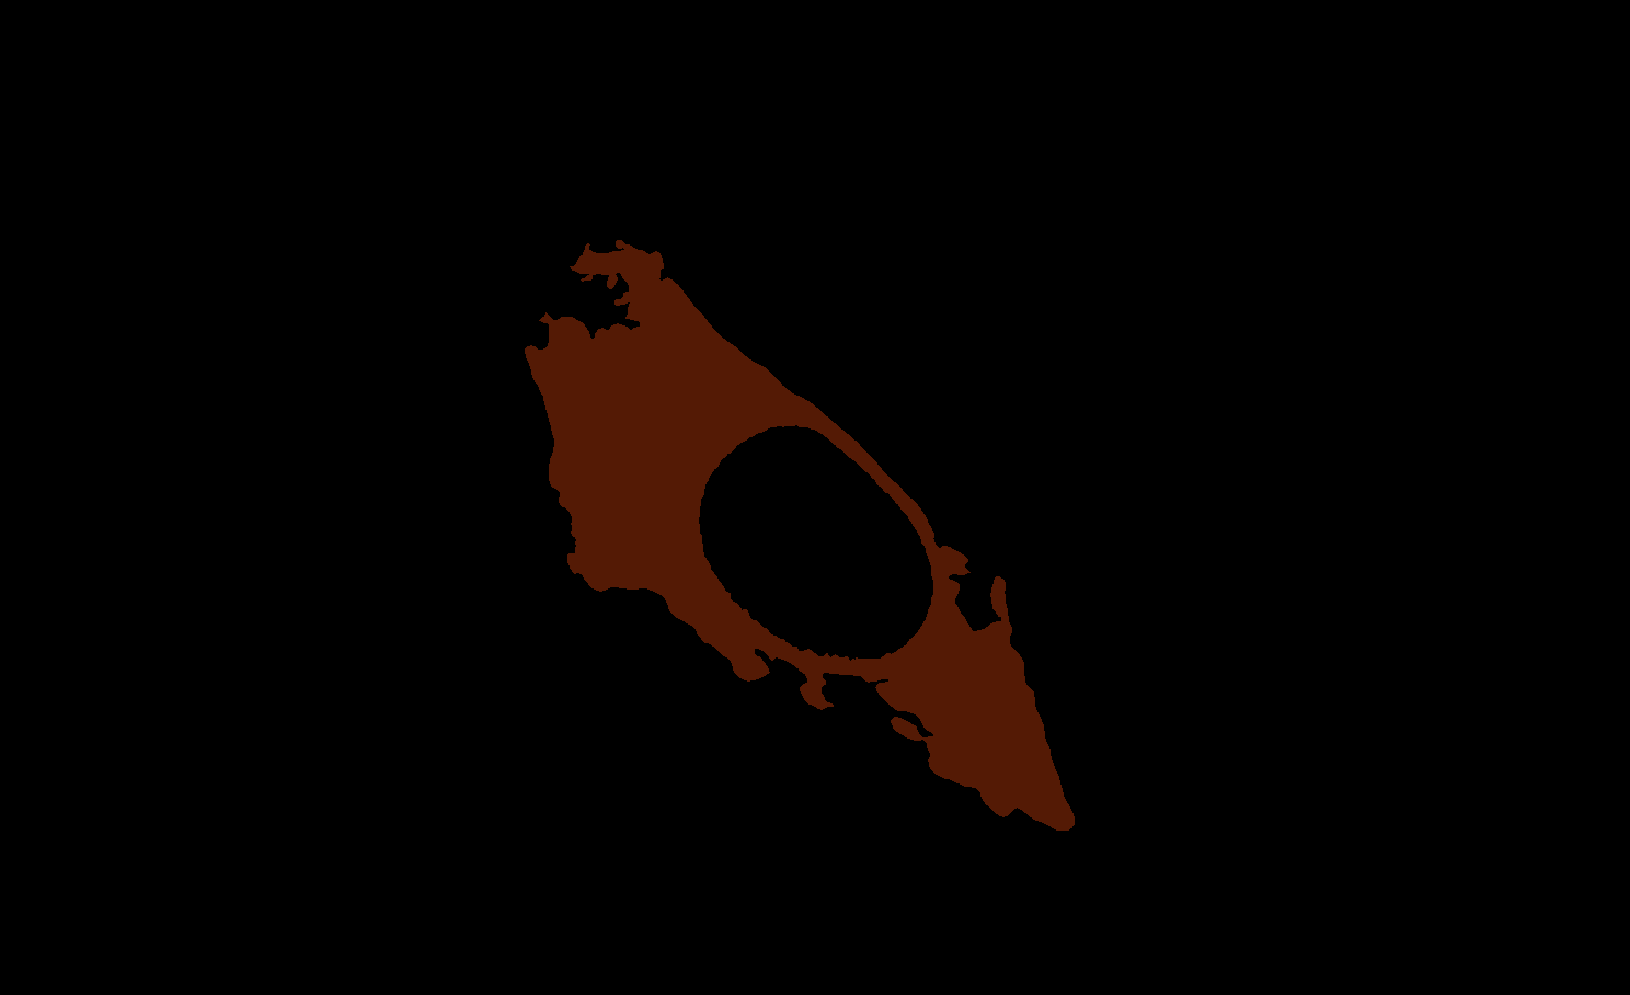

In [18]:
from napari.utils.notebook_display import nbscreenshot

nbscreenshot(viewer, canvas_only=True)

In [19]:
viewer.close()

-------------
## SUMMARY

The above details how the cytoplasm mask is inferred. 

### NEXT: INFER LYSOSOME

proceed to [04_infer_lysosome.ipynb](./04_infer_lysosome.ipynb)
